<a href="https://colab.research.google.com/github/perryqen06/ai-science-training-series/blob/main/2024-Nov-5_PerryC_ss6(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks to the great instruction and help the model was able to run  on Colab (due to unsuccessful access to ALCF account despite continuous attempts).

Attached are screenshots from the colab run: prior_to_Training, post_Training (loss from 205.674 to  1.23598) and final evaluation. The model has been meaningfully trained to generate Shakespeare-style conversations.


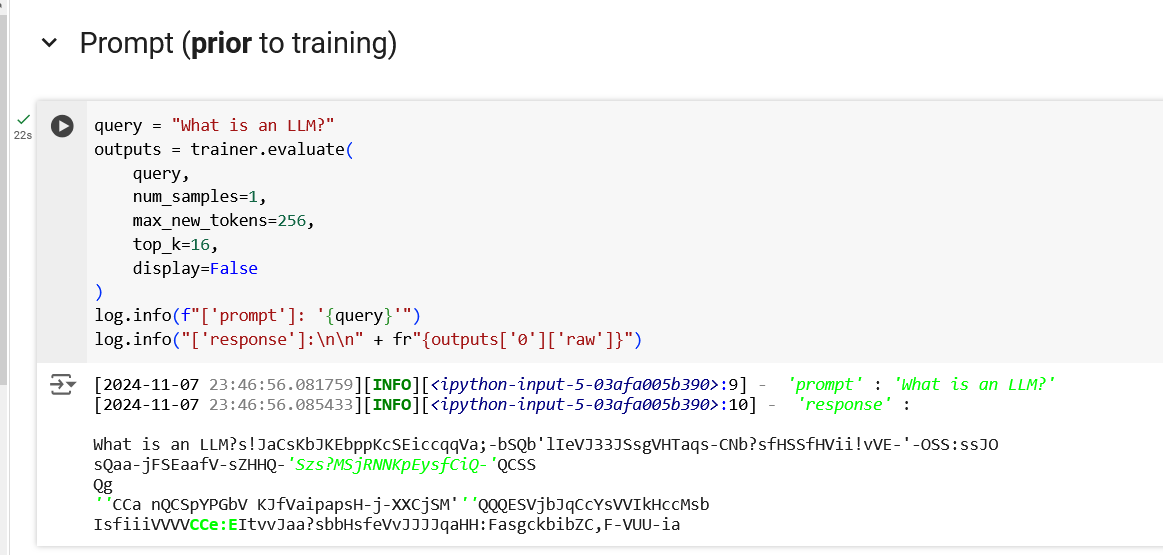


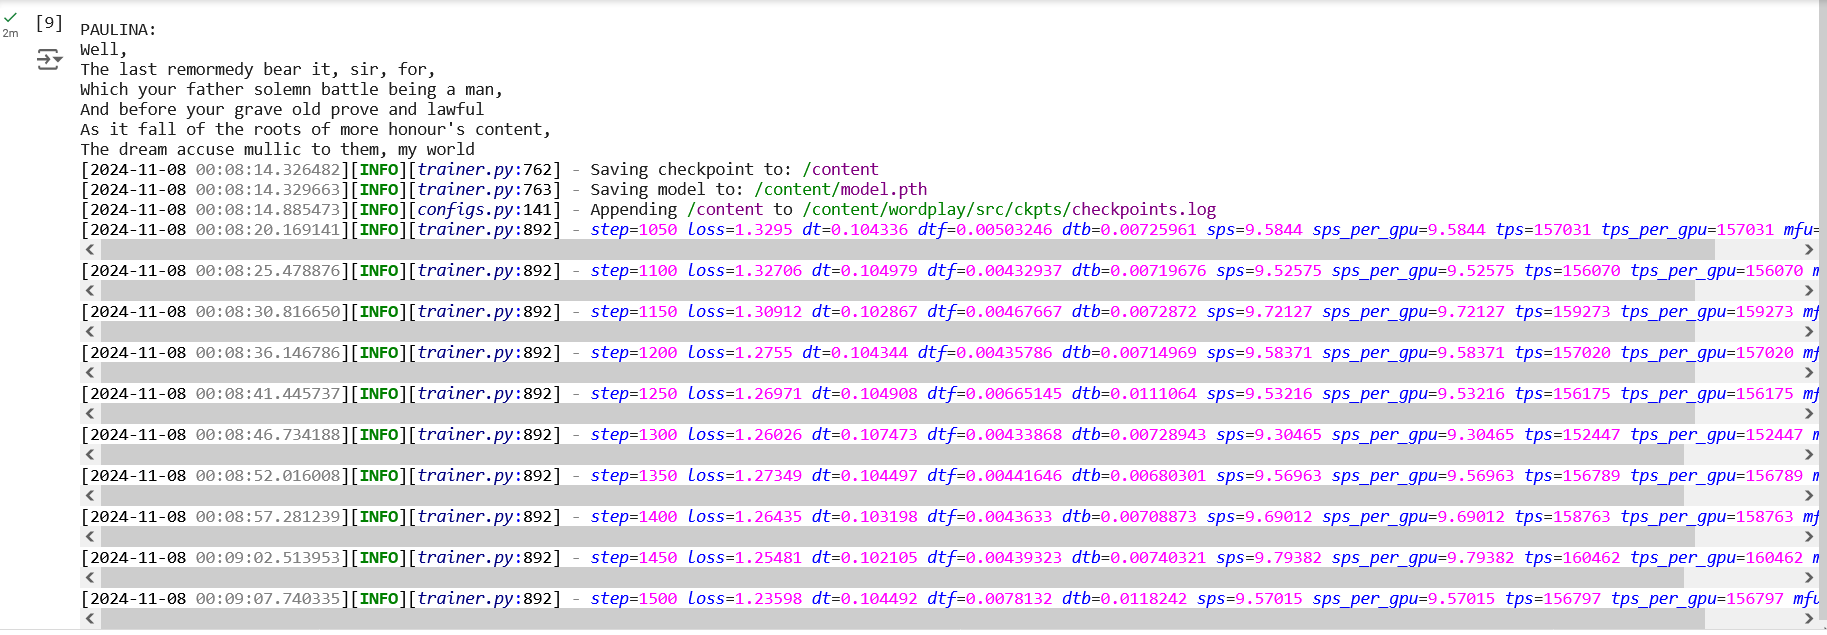






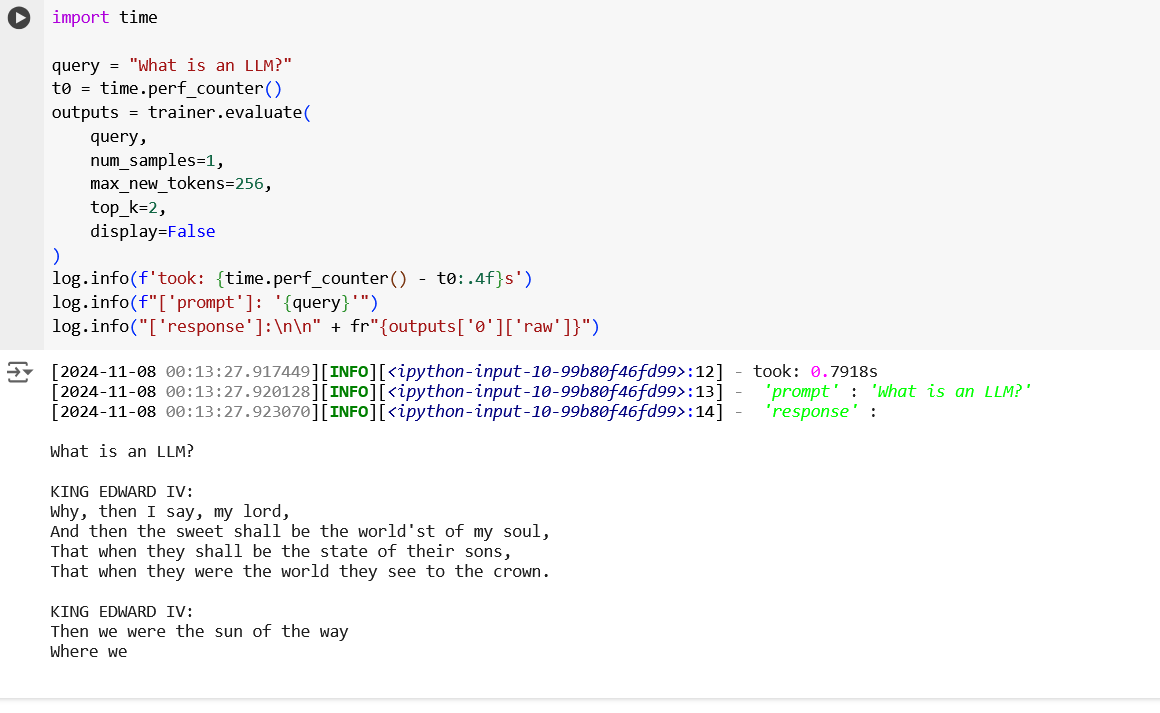

# [`wordplay` 🎮 💬](https://github.com/saforem2/wordplay): Shakespeare ✍️

We will be using the [Shakespeare dataset](https://github.com/saforem2/wordplay/blob/main/data/shakespeare/readme.md) to train a (~ small) 10M param LLM _from scratch_.

<div>

<div align="center" style="text-align:center;">

<img src="https://github.com/saforem2/wordplay/blob/main/assets/shakespeare.jpeg?raw=true" width="45%" align="center" /><br>

Image generated from [stabilityai/stable-diffusion](https://huggingface.co/spaces/stabilityai/stable-diffusion) on [🤗 Spaces](https://huggingface.co/spaces).<br>

</div>

<details closed><summary>Prompt Details</summary>

<ul>
<li>Prompt:</li>
<t><q>
Shakespeare himself, dressed in full Shakespearean garb,
writing code at a modern workstation with multiple monitors, hacking away profusely,
backlit, high quality for publication
</q></t>

<li>Negative Prompt:</li>
<t><q>
low quality, 3d, photorealistic, ugly
</q></t>
</ul>

</details>

</div>

## Install / Setup

<div class="alert alert-block alert-warning">
<b>Warning!</b><br>  

**IF YOU ARE EXECUTING ON GOOGLE COLAB**:  

You will need to restart your runtime (`Runtime` $\rightarrow\,$ `Restart runtime`)  
_after_ executing the following cell:

</div>

In [ ]:
%%bash

python3 -c 'import wordplay; print(wordplay.__file__)' 2> '/dev/null'

if [[ $? -eq 0 ]]; then
    echo "Has wordplay installed. Nothing to do."
else
    echo "Does not have wordplay installed. Installing..."

    git clone 'https://github.com/saforem2/wordplay'
    python3 -m pip install -r wordplay/requirements.txt
    python3 wordplay/data/shakespeare_char/prepare.py
    python3 wordplay/data/shakespeare/prepare.py
    python3 -m pip install deepspeed
    python3 -m pip install -e wordplay
fi

Does not have wordplay installed. Installing...
Using HF_DATASETS_CACHE=/content/wordplay/data/shakespeare_char/.cache/huggingface
length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.7 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.15.3-py3-none-any.whl size=1526202 sha256=0b5ec5cae6ef6fe44d935229e7985849b0504f725efe2f30d20db9d21d658b36
  Stored in directory: /root/.cache/pip/wheels/b3/c2/9f/37a2c813b8d64d7908793319cfdfa4f8527

Cloning into 'wordplay'...
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'wordplay/requirements.txt'
Traceback (most recent call last):
  File "/content/wordplay/data/shakespeare/prepare.py", line 7, in <module>
    import tiktoken
ModuleNotFoundError: No module named 'tiktoken'
  Running command git clone --filter=blob:none --quiet https://github.com/saforem2/ambivalent /tmp/pip-install-c3y4x3ev/ambivalent_646f89da5db74af59df7302ea4be26c1
  Running command git clone --filter=blob:none --quiet https://github.com/saforem2/ezpz /tmp/pip-install-c3y4x3ev/ezpz_db9027ed18e94231a2c3079349cf9359
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


## Post Install

If installed correctly, you should be able to:

```python
>>> import wordplay
>>> wordplay.__file__
'/path/to/wordplay/src/wordplay/__init__.py'
```

In [ ]:
%load_ext autoreload
%autoreload 2
import os

os.environ['COLORTERM'] = 'truecolor'
# If running on MacOS:
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
# -----------------------------------------------

from ezpz import get_logger
log = get_logger(level='INFO')

import wordplay
log.info(wordplay.__file__)

[2024-11-08 05:17:49.669766][INFO][<ipython-input-1-11aa8b4c39fe>:14] - /content/wordplay/src/wordplay/__init__.py

## Build Trainer

Explicitly, we:

1. `setup_torch(...)`
2. Build `cfg: DictConfig = get_config(...)`
3. Instnatiate `config: ExperimentConfig = instantiate(cfg)`
4. Build `trainer = Trainer(config)`

In [ ]:
import os
import numpy as np
from ezpz import setup
from hydra.utils import instantiate
from wordplay.configs import get_config, PROJECT_ROOT
from wordplay.trainer import Trainer

HF_DATASETS_CACHE = PROJECT_ROOT.joinpath('.cache', 'huggingface')
HF_DATASETS_CACHE.mkdir(exist_ok=True, parents=True)

os.environ['HF_DATASETS_CACHE'] = HF_DATASETS_CACHE.as_posix()

BACKEND = 'DDP'

rank = setup(
    framework='pytorch',
    backend=BACKEND,
    seed=1234,
)

cfg = get_config(
    [
        'data=shakespeare',
        'model=shakespeare',
        'optimizer=shakespeare',
        'train=shakespeare',
        f'train.backend={BACKEND}',
        'train.compile=false',
        'train.dtype=float16',
        'train.max_iters=1000',
        'train.log_interval=50',
        'train.eval_interval=500',
    ]
)
config = instantiate(cfg)

[2024-11-08 05:18:15.525307][INFO][configs.py:81] - Setting HF_DATASETS_CACHE to /content/wordplay/.cache/huggingface/datasets

[2024-11-08 05:18:15.578427][INFO][dist.py:92] - 

[dist_info]:
  • DEVICE=cuda
  • DEVICE_ID=cuda:0
  • DISTRIBUTED_BACKEND=nccl
  • GPUS_PER_NODE=1
  • HOSTS=['3c4ace3e92a6']
  • HOSTFILE=/content/hostfile
  • HOSTNAME=3c4ace3e92a6
  • LOCAL_RANK=0
  • MACHINE=3c4ace3e92a6
  • NUM_NODES=1
  • NGPUS=1
  • NGPUS_AVAILABLE=1
  • NODE_ID=0
  • RANK=0
  • SCHEDULER=LOCAL
  • WORLD_SIZE_TOTAL=1
  • WORLD_SIZE_IN_USE=1
  • LAUNCH_CMD=None

[2024-11-08 05:18:15.583568][INFO][dist.py:728] - [0/1] Using device='cuda' with backend='DDP' + 'nccl' for distributed training.

[2024-11-08 05:18:15.588932][INFO][dist.py:348] - [device='cuda'][rank=0/0][local_rank=0/0][node=0/0]

[2024-11-08 05:18:15.592515][WARNING][dist.py:352] - Using [1 / 1] available "cuda" devices !!

[2024-11-08 05:18:15.771528][INFO][configs.py:317] - Loading train from /content/wordplay/data/shakespeare_char/train.bin

[2024-11-08 05:18:15.774977][INFO][configs.py:317] - Loading val from /content/wordplay/data/shakespeare_char/val.bin

[2024-11-08 05:18:15.779837][INFO][configs.py:442] - Tokens per iteration: 16,384

[2024-11-08 05:18:15.783369][INFO][configs.py:465] - Using self.ptdtype=torch.float16 on self.device_type='cuda'

[2024-11-08 05:18:15.786797][INFO][configs.py:471] - Initializing a new model from scratch

### Build `Trainer` object

In [ ]:
trainer = Trainer(config)

[2024-11-08 05:21:41.524502][INFO][trainer.py:248] - Initializing a new model from scratch

[2024-11-08 05:21:41.908516][INFO][model.py:255] - number of parameters: 10.65M

[2024-11-08 05:21:42.176921][INFO][trainer.py:266] - Model size: num_params=10646784

[2024-11-08 05:21:42.183940][INFO][model.py:445] - num decayed parameter tensors: 26, with 10,740,096 parameters

[2024-11-08 05:21:42.187379][INFO][model.py:449] - num non-decayed parameter tensors: 13, with 4,992 parameters

[2024-11-08 05:21:43.666520][INFO][model.py:465] - using fused AdamW: True

/content/wordplay/src/wordplay/trainer.py:303: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler(


[2024-11-08 05:21:43.670266][CRITICAL][trainer.py:318] - "devid='cuda:0'"

[2024-11-08 05:21:43.680865][INFO][trainer.py:358] - • self.model=GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (act_fn): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=65, bias=False)
)

[2024-11-08 05:21:43.690056][INFO][trainer.py:359] - • self.grad_scaler=<torch.cuda.amp.grad_scaler.GradScaler object at 0x7ca06f12d090>

[2024-11-08 05:21:43.693819][INFO][trainer.py:360] - • self.model_engine=GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (act_fn): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=65, bias=False)
)

[2024-11-08 05:21:43.705529][INFO][trainer.py:361] - • self.optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.001
    maximize: False
    weight_decay: 0.1

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)

## Prompt (**prior** to training)

In [ ]:
query = "What is an LLM?"
outputs = trainer.evaluate(
    query,
    num_samples=1,
    max_new_tokens=256,
    top_k=16,
    display=True
)
log.info(f"['prompt']: '{query}'")
log.info("['response']:\n\n" + fr"{outputs['0']['raw']}")

[2024-11-08 05:23:08.678974][INFO][trainer.py:979] - [prompt]: 'What is an LLM?:IQIi-VV'V-'peHQK'sQVbHcpAibsalHbbbbEGffSH:sB:QVhRVSVb--Z'

[2024-11-08 05:23:08.682142][INFO][trainer.py:980] - > ZKMiI:sff:MHVbbVbbdd-ZbkiJHbS:yaafIKHHHS'la'hbs?wVVSCCiiX'aqsb-ZvQJJHHb''-hsHHaiY,EEaUV',qCeb
> oLlZpIIjppbbJf-KayyC:vHHa KJJ
> 'CrVY::G:sbbaf:sQhipNt,
> 'sVYipJpYC'SKiq$$iSSMsaacPa,QbIKttKK--wFbFFaiVEiii

[2024-11-08 05:23:08.685833][INFO][<ipython-input-5-49a42458dcaa>:9] - ['prompt']: 'What is an LLM?'

[2024-11-08 05:23:08.689590][INFO][<ipython-input-5-49a42458dcaa>:10] - ['response']:

What is an LLM?:IQIi-VV'V-'peHQK'sQVbHcpAibsalHbbbbEGffSH:sB:QVhRVSVb--Z
ZKMiI:sff:MHVbbVbbdd-ZbkiJHbS:yaafIKHHHS'la'hbs?wVVSCCiiX'aqsb-ZvQJJHHb''-hsHHaiY,EEaUV',qCeb
oLlZpIIjppbbJf-KayyC:vHHa KJJ
'CrVY::G:sbbaf:sQhipNt,
'sVYipJpYC'SKiq$$iSSMsaacPa,QbIKttKK--wFbFFaiVEiii

## Train Model

|  name  |       description            |
|:------:|:----------------------------:|
| `step` | Current training step        |
| `loss` | Loss value                   |
| `dt`   | Time per step (in **ms**)    |
| `sps`  | Samples per second           |
| `mtps` | (million) Tokens per sec     |
| `mfu`  | Model Flops utilization[^1]  |
^legend: #tbl-legend

[^1]: in units of A100 `bfloat16` peak FLOPS

In [ ]:
trainer.config.device_type

'cuda'

In [ ]:
from rich import print

print(trainer.model)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(65, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (act_fn): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=65, bias=False)
)

## (partial) Training:

We'll first train for 500 iterations and then evaluate the models performance on the same prompt:

> What is an LLM?

In [ ]:
trainer.train(train_iters=500)

                Training Legend                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        abbr ┃ desc                           ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        step │ Current training iteration     │
│        loss │ Loss value                     │
│          dt │ Elapsed time per training step │
│         dtf │ Elapsed time per forward step  │
│         dtb │ Elapsed time per backward step │
│         sps │ Samples per second             │
│ sps_per_gpu │ Samples per second (per GPU)   │
│         tps │ Tokens per second              │
│ tps_per_gpu │ Tokens per second (per GPU)    │
│         mfu │ Model flops utilization        │
└─────────────┴────────────────────────────────┘

[2024-11-08 05:24:45.883338][INFO][trainer.py:827] - ['prompt']: 'What is an LLM?'

[2024-11-08 05:24:45.886013][INFO][trainer.py:831] - ['response']:

What is an LLM?k,,,,  fIHEHsEvsGVsIs''sfNMIQHHSHVVtissQVNZ CHGqafSSSkb.--HEHKK, ffaJQQJJqJJQNNfqkkHv-QBSaKEEVvXVZ3QabswwIEqsVtqrSyQ--jBafH'33QIfpq--ankS
bssaSpEaHHH?ashKaSeXX-aaIIJSqvUHBBSSSDaiaO-afqppCCCa::wE--YEQGf?CVhCcJibbQMIjaa?apJqqIHiLSiq''HHHNanJJJQsa-ZvEEkHhEYba

[2024-11-08 05:25:03.313812][INFO][trainer.py:892] - step=50 loss=2.50536 dt=0.0951422 dtf=0.00437039 dtb=0.00685079 sps=10.5106 sps_per_gpu=10.5106 tps=172205 tps_per_gpu=172205 mfu=3.91649

[2024-11-08 05:25:08.159951][INFO][trainer.py:892] - step=100 loss=2.48167 dt=0.100002 dtf=0.00706379 dtb=0.0128566 sps=9.99976 sps_per_gpu=9.99976 tps=163836 tps_per_gpu=163836 mfu=3.89746

[2024-11-08 05:25:13.056142][INFO][trainer.py:892] - step=150 loss=2.42007 dt=0.0991337 dtf=0.00443665 dtb=0.00697066 sps=10.0874 sps_per_gpu=10.0874 tps=165272 tps_per_gpu=165272 mfu=3.88359

[2024-11-08 05:25:17.978772][INFO][trainer.py:892] - step=200 loss=2.26795 dt=0.0994601 dtf=0.00442648 dtb=0.00693984 sps=10.0543 sps_per_gpu=10.0543 tps=164729 tps_per_gpu=164729 mfu=3.86988

[2024-11-08 05:25:22.921090][INFO][trainer.py:892] - step=250 loss=2.06456 dt=0.0976051 dtf=0.00431692 dtb=0.00712179 sps=10.2454 sps_per_gpu=10.2454 tps=167860 tps_per_gpu=167860 mfu=3.86466

[2024-11-08 05:25:27.889243][INFO][trainer.py:892] - step=300 loss=1.92141 dt=0.101356 dtf=0.0049911 dtb=0.00686963 sps=9.86622 sps_per_gpu=9.86622 tps=161648 tps_per_gpu=161648 mfu=3.84583

[2024-11-08 05:25:32.939010][INFO][trainer.py:892] - step=350 loss=1.79536 dt=0.0931828 dtf=0.00679681 dtb=0.00966938 sps=10.7316 sps_per_gpu=10.7316 tps=175826 tps_per_gpu=175826 mfu=3.86113

[2024-11-08 05:25:37.997473][INFO][trainer.py:892] - step=400 loss=1.73486 dt=0.101175 dtf=0.0042673 dtb=0.0069322 sps=9.8839 sps_per_gpu=9.8839 tps=161938 tps_per_gpu=161938 mfu=3.84332

[2024-11-08 05:25:43.058861][INFO][trainer.py:892] - step=450 loss=1.68148 dt=0.101949 dtf=0.00433356 dtb=0.00692518 sps=9.80879 sps_per_gpu=9.80879 tps=160707 tps_per_gpu=160707 mfu=3.82448

[2024-11-08 05:25:48.141039][INFO][trainer.py:892] - step=500 loss=1.60571 dt=0.100799 dtf=0.00441345 dtb=0.0071194 sps=9.9207 sps_per_gpu=9.9207 tps=162541 tps_per_gpu=162541 mfu=3.8117

In [ ]:
import time

query = "What is an LLM?"
t0 = time.perf_counter()
outputs = trainer.evaluate(
    query,
    num_samples=1,
    max_new_tokens=256,
    top_k=16,
    display=False
)
log.info(f'took: {time.perf_counter() - t0:.4f}s')
log.info(f"['prompt']: '{query}'")
log.info("['response']:\n\n" + fr"{outputs['0']['raw']}")

[2024-11-08 05:29:04.825248][INFO][<ipython-input-9-18639f76aec6>:12] - took: 1.1311s

[2024-11-08 05:29:04.829937][INFO][<ipython-input-9-18639f76aec6>:13] - ['prompt']: 'What is an LLM?'

[2024-11-08 05:29:04.832995][INFO][<ipython-input-9-18639f76aec6>:14] - ['response']:

What is an LLM?

RADY ANNE:
Why good of the wrown the man.

DUKE VINCENTIO:
They abidge of the gentle well hasten to leave their dewine.

FLORIZEL:
So more me good manness would despectors against him in these?
What his dame?

GLOUCESTER:
And it say the people in this re

## Resume Training...

In [ ]:
trainer.train()

[2024-11-08 00:06:56.839677][INFO][trainer.py:827] - ['prompt']: 'What is an LLM?'

[2024-11-08 00:06:56.843034][INFO][trainer.py:831] - ['response']:

What is an LLM?

TRANIONIO:
Why good of the wrongs worse well.

SICINIUS:
O cannot is to with will as not me speak the conting?

BUCKINGHAM:
Madam thou bed me?

ANGELO:
Marry, sir, sir, ho desp you not dow, so?
What is you with the live
Of much than the people in this.

[2024-11-08 00:07:09.112937][INFO][trainer.py:762] - Saving checkpoint to: /content

[2024-11-08 00:07:09.115349][INFO][trainer.py:763] - Saving model to: /content/model.pth

[2024-11-08 00:07:09.520021][INFO][configs.py:141] - Appending /content to /content/wordplay/src/ckpts/checkpoints.log

[2024-11-08 00:07:14.498763][INFO][trainer.py:892] - step=550 loss=1.57958 dt=0.107161 dtf=0.00707209 dtb=0.0105243 sps=9.33174 sps_per_gpu=9.33174 tps=152891 tps_per_gpu=152891 mfu=3.47723

[2024-11-08 00:07:19.473834][INFO][trainer.py:892] - step=600 loss=1.52222 dt=0.101075 dtf=0.00545796 dtb=0.00739125 sps=9.89361 sps_per_gpu=9.89361 tps=162097 tps_per_gpu=162097 mfu=3.49816

[2024-11-08 00:07:24.492986][INFO][trainer.py:892] - step=650 loss=1.51314 dt=0.102358 dtf=0.00622334 dtb=0.010354 sps=9.7696 sps_per_gpu=9.7696 tps=160065 tps_per_gpu=160065 mfu=3.51239

[2024-11-08 00:07:29.529272][INFO][trainer.py:892] - step=700 loss=1.45362 dt=0.100401 dtf=0.00472873 dtb=0.00738034 sps=9.96008 sps_per_gpu=9.96008 tps=163186 tps_per_gpu=163186 mfu=3.53228

[2024-11-08 00:07:34.593385][INFO][trainer.py:892] - step=750 loss=1.42322 dt=0.0993816 dtf=0.00430793 dtb=0.00698339 sps=10.0622 sps_per_gpu=10.0622 tps=164860 tps_per_gpu=164860 mfu=3.554

[2024-11-08 00:07:39.656085][INFO][trainer.py:892] - step=800 loss=1.43307 dt=0.100135 dtf=0.00461758 dtb=0.00747293 sps=9.98653 sps_per_gpu=9.98653 tps=163619 tps_per_gpu=163619 mfu=3.57072

[2024-11-08 00:07:44.751463][INFO][trainer.py:892] - step=850 loss=1.41574 dt=0.101301 dtf=0.00466093 dtb=0.00750105 sps=9.87161 sps_per_gpu=9.87161 tps=161736 tps_per_gpu=161736 mfu=3.58149

[2024-11-08 00:07:49.898708][INFO][trainer.py:892] - step=900 loss=1.38289 dt=0.106711 dtf=0.00680892 dtb=0.0112572 sps=9.37109 sps_per_gpu=9.37109 tps=153536 tps_per_gpu=153536 mfu=3.57253

[2024-11-08 00:07:55.084000][INFO][trainer.py:892] - step=950 loss=1.35019 dt=0.100931 dtf=0.00466838 dtb=0.00744134 sps=9.90774 sps_per_gpu=9.90774 tps=162328 tps_per_gpu=162328 mfu=3.58446

[2024-11-08 00:08:00.257605][INFO][trainer.py:892] - step=1000 loss=1.3418 dt=0.105038 dtf=0.00424622 dtb=0.00703662 sps=9.52039 sps_per_gpu=9.52039 tps=155982 tps_per_gpu=155982 mfu=3.58077

[2024-11-08 00:08:01.181815][INFO][trainer.py:827] - ['prompt']: 'What is an LLM?'

[2024-11-08 00:08:01.185095][INFO][trainer.py:831] - ['response']:

What is an LLM?

LADY ANNE:
You know?

PAULINA:
Well,
The last remormedy bear it, sir, for,
Which your father solemn battle being a man,
And before your grave old prove and lawful
As it fall of the roots of more honour's content,
The dream accuse mullic to them, my world

[2024-11-08 00:08:14.326482][INFO][trainer.py:762] - Saving checkpoint to: /content

[2024-11-08 00:08:14.329663][INFO][trainer.py:763] - Saving model to: /content/model.pth

[2024-11-08 00:08:14.885473][INFO][configs.py:141] - Appending /content to /content/wordplay/src/ckpts/checkpoints.log

[2024-11-08 00:08:20.169141][INFO][trainer.py:892] - step=1050 loss=1.3295 dt=0.104336 dtf=0.00503246 dtb=0.00725961 sps=9.5844 sps_per_gpu=9.5844 tps=157031 tps_per_gpu=157031 mfu=3.57983

[2024-11-08 00:08:25.478876][INFO][trainer.py:892] - step=1100 loss=1.32706 dt=0.104979 dtf=0.00432937 dtb=0.00719676 sps=9.52575 sps_per_gpu=9.52575 tps=156070 tps_per_gpu=156070 mfu=3.5768

[2024-11-08 00:08:30.816650][INFO][trainer.py:892] - step=1150 loss=1.30912 dt=0.102867 dtf=0.00467667 dtb=0.0072872 sps=9.72127 sps_per_gpu=9.72127 tps=159273 tps_per_gpu=159273 mfu=3.58135

[2024-11-08 00:08:36.146786][INFO][trainer.py:892] - step=1200 loss=1.2755 dt=0.104344 dtf=0.00435786 dtb=0.00714969 sps=9.58371 sps_per_gpu=9.58371 tps=157020 tps_per_gpu=157020 mfu=3.58033

[2024-11-08 00:08:41.445737][INFO][trainer.py:892] - step=1250 loss=1.26971 dt=0.104908 dtf=0.00665145 dtb=0.0111064 sps=9.53216 sps_per_gpu=9.53216 tps=156175 tps_per_gpu=156175 mfu=3.57749

[2024-11-08 00:08:46.734188][INFO][trainer.py:892] - step=1300 loss=1.26026 dt=0.107473 dtf=0.00433868 dtb=0.00728943 sps=9.30465 sps_per_gpu=9.30465 tps=152447 tps_per_gpu=152447 mfu=3.56645

[2024-11-08 00:08:52.016008][INFO][trainer.py:892] - step=1350 loss=1.27349 dt=0.104497 dtf=0.00441646 dtb=0.00680301 sps=9.56963 sps_per_gpu=9.56963 tps=156789 tps_per_gpu=156789 mfu=3.56639

[2024-11-08 00:08:57.281239][INFO][trainer.py:892] - step=1400 loss=1.26435 dt=0.103198 dtf=0.0043633 dtb=0.00708873 sps=9.69012 sps_per_gpu=9.69012 tps=158763 tps_per_gpu=158763 mfu=3.57083

[2024-11-08 00:09:02.513953][INFO][trainer.py:892] - step=1450 loss=1.25481 dt=0.102105 dtf=0.00439323 dtb=0.00740321 sps=9.79382 sps_per_gpu=9.79382 tps=160462 tps_per_gpu=160462 mfu=3.57869

[2024-11-08 00:09:07.740335][INFO][trainer.py:892] - step=1500 loss=1.23598 dt=0.104492 dtf=0.0078132 dtb=0.0118242 sps=9.57015 sps_per_gpu=9.57015 tps=156797 tps_per_gpu=156797 mfu=3.57743

## Evaluate Model

In [ ]:
import time

query = "What is an LLM?"
t0 = time.perf_counter()
outputs = trainer.evaluate(
    query,
    num_samples=1,
    max_new_tokens=256,
    top_k=2,
    display=False
)
log.info(f'took: {time.perf_counter() - t0:.4f}s')
log.info(f"['prompt']: '{query}'")
log.info("['response']:\n\n" + fr"{outputs['0']['raw']}")

[2024-11-08 05:29:21.164063][INFO][<ipython-input-10-99b80f46fd99>:12] - took: 0.8170s

[2024-11-08 05:29:21.166561][INFO][<ipython-input-10-99b80f46fd99>:13] - ['prompt']: 'What is an LLM?'

[2024-11-08 05:29:21.169822][INFO][<ipython-input-10-99b80f46fd99>:14] - ['response']:

What is an LLM?

LEONTES:
Well the world so the was of the could the words,
And that the world the wast of the world shall deserves of the ward.

LEONTES:
Well, sir, thou should thou see the common to the warl.

GLOUCESTER:
I would the do the world the world stand the de